<a href="https://colab.research.google.com/github/tincho-mehaudy/DMCyT/blob/master/TP1_Consigna1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install spotipy
!pip -q install -U librosa
#!wget -q https://www.dropbox.com/s/nqjs076fidighaz/SopSax.NoVib.mf.C4B4.wav?dl=1 -O SopSax.NoVib.mf.C4B4.wav

     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sns.set_context('poster')

ModuleNotFoundError: ignored

# Consigna 1:

Utilizando la API de Spotify se descargó la información de 4092 pistas de audio. Cada registro tiene variables de features de alto (*audio_features*), bajo nivel (*audio_analysis*) y metadata de los tracks. La idea es limpiar los campos a utilizar y hacer un primer análisis de los datos.

Para facilitar los primeros pasos utilizar una pequeña porción aleatoria de los datos e ir aumentando progresivamente. Observación: los datos de *audio_analysis* pesan 1.3 GB

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

# Dataset *audio_features*

El dataset *audio_features* contiene 9 atributos globales de alto nivel para cada pista de audio.

-   Con los datos de *audio_features*, generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

# Dataset *audio_analysis*

El dataset *audio_analysis* contiene las variables continuas de bajo nivel, estimadas en ventanas temporales, como *timbre* o *pitches*. Como primer paso, deberán:

-   Resumir estas variables en valores por canción. Por ejemplo, tomar el promedio o el desvío estándar del timbre entre todas las ventanas, obteniendo 12 valores de timbre promedio y 12 valores de desvío estándar del timbre por canción.

-   Contruir un *data frame* con estos valores.

-   Generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

## Bajamos los datos 



In [2]:
!wget https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1 -O audio_features.pickle
!wget https://www.dropbox.com/s/8d0y9bms80ly8ui/tracks.pickle?dl=1 -O tracks.pickle
!wget https://www.dropbox.com/s/1cmb8e8zvv6hsfs/audio_analysis.pickle?dl=1 -O audio_analysis.pickle

--2020-09-22 22:05:28--  https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ms6260jqmsmz5qu/audio_features.pickle [following]
--2020-09-22 22:05:28--  https://www.dropbox.com/s/dl/ms6260jqmsmz5qu/audio_features.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4efc9814ee2dc1986838eaf037.dl.dropboxusercontent.com/cd/0/get/A_7z2QfR37_dOza3gf6T9zdBR1NnDh7ywBpKsOd_ekITyfVJqdrdzUVikHG-HeUupKXyEzfoYzR33tMdBNgmGKtp296k_d8-PeK7XgJgFsZgENPGJtiwXYrVk18PL3hW-6I/file?dl=1# [following]
--2020-09-22 22:05:29--  https://uc4efc9814ee2dc1986838eaf037.dl.dropboxusercontent.com/cd/0/get/A_7z2QfR37_dOza3gf6T9zdBR1NnDh7ywBpKsOd_ekITyfVJqdrdzUVikHG-HeUupKXyEzfoYzR33tMdBN

In [3]:
import pandas as pd
import numpy as np

df_af = pd.read_pickle('audio_features.pickle')
df_tracks = pd.read_pickle('tracks.pickle')
df_aa = pd.read_pickle('audio_analysis.pickle')

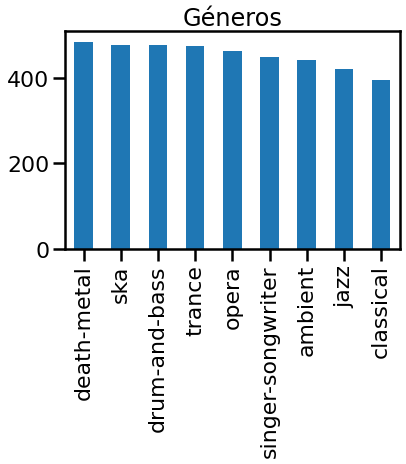

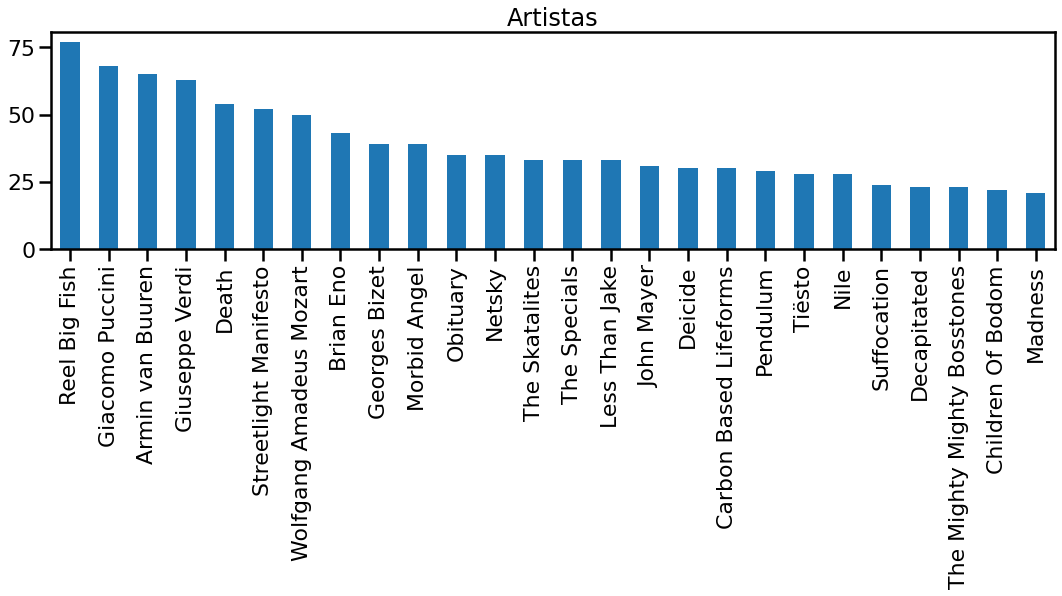

In [ ]:
import matplotlib.pyplot as plt
df_tracks['genre'].value_counts().plot.bar(figsize=(6,4));
plt.title('Géneros')
plt.show()
df_tracks['artists'].value_counts()[:26].plot.bar(figsize=(18,4));
plt.title('Artistas');

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

In [6]:
df_tracks.head()

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,is_local,name,popularity,preview_url,track_number,type,uri,genre
id,,,,,,,,,,,,,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,"{'album_type': 'ALBUM', 'artists': [{'external...",Tommy Flanagan,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,349600,False,{'isrc': 'USEWJ0702033'},{'spotify': 'https://open.spotify.com/track/4d...,https://api.spotify.com/v1/tracks/4d3XHYFFuYYz...,False,Angel Eyes - Studio,49,https://p.scdn.co/mp3-preview/10e213fc96d2f614...,3,track,spotify:track:4d3XHYFFuYYzxWr2cJ6yQl,jazz
3X3p3u03P8eFL8WTH0oaaU,"{'album_type': 'ALBUM', 'artists': [{'external...",Art Farmer,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,344066,False,{'isrc': 'USBN29100147'},{'spotify': 'https://open.spotify.com/track/3X...,https://api.spotify.com/v1/tracks/3X3p3u03P8eF...,False,Fair Weather - Remastered,47,None,2,track,spotify:track:3X3p3u03P8eFL8WTH0oaaU,jazz
4KlXeaheot0OI9PoOWspvZ,"{'album_type': 'ALBUM', 'artists': [{'external...",Christian Scott aTunde Adjuah,"[CA, US]",1,348746,False,{'isrc': 'USC4R0714598'},{'spotify': 'https://open.spotify.com/track/4K...,https://api.spotify.com/v1/tracks/4KlXeaheot0O...,False,Cease Fire,13,None,5,track,spotify:track:4KlXeaheot0OI9PoOWspvZ,jazz
3j76McoUI18gDoqxYE14Bu,"{'album_type': 'ALBUM', 'artists': [{'external...",Skalpel,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",1,275935,False,{'isrc': 'PLK281400008'},{'spotify': 'https://open.spotify.com/track/3j...,https://api.spotify.com/v1/tracks/3j76McoUI18g...,False,Sea,25,https://p.scdn.co/mp3-preview/d154ecaf7df8206c...,8,track,spotify:track:3j76McoUI18gDoqxYE14Bu,jazz
4zxd4tiXPlWMqoJltbVTbE,"{'album_type': 'ALBUM', 'artists': [{'external...",Miles Davis,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",2,284560,False,{'isrc': 'USSM15800962'},{'spotify': 'https://open.spotify.com/track/4z...,https://api.spotify.com/v1/tracks/4zxd4tiXPlWM...,False,Stella By Starlight,56,https://p.scdn.co/mp3-preview/a4430030bca4c02c...,3,track,spotify:track:4zxd4tiXPlWMqoJltbVTbE,jazz


In [7]:
df_tracks.columns

Index(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms',
       'explicit', 'external_ids', 'external_urls', 'href', 'is_local', 'name',
       'popularity', 'preview_url', 'track_number', 'type', 'uri', 'genre'],
      dtype='object')

In [27]:
df2 = df_tracks[['artists','album','genre']]
df2['release_date'] =df2['album'].apply(pd.Series)['release_date'].apply(str)
df2['release_date'] =df2['release_date'].str.slice(0, 4)

#date=df_tracks['album'].apply(pd.Series)['release_date'].apply(str)
#date.apply([0:4])
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,artists,album,genre,release_date
id,,,,
4d3XHYFFuYYzxWr2cJ6yQl,Tommy Flanagan,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,1991
3X3p3u03P8eFL8WTH0oaaU,Art Farmer,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,1958
4KlXeaheot0OI9PoOWspvZ,Christian Scott aTunde Adjuah,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,2014
3j76McoUI18gDoqxYE14Bu,Skalpel,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,2014
4zxd4tiXPlWMqoJltbVTbE,Miles Davis,"{'album_type': 'ALBUM', 'artists': [{'external...",jazz,1959


In [26]:
# no se bien que tiene este campo de available markets
df_temp=df_tracks['album'].apply(pd.Series)
df_available = df_temp.available_markets.apply(pd.Series)
df_available.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,AD,AE,AL,AR,AT,AU,BA,BE,BG,BH,BO,BR,BY,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HR,HU,ID,IE,IL,...,MA,MC,MD,ME,MK,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,RS,RU,SA,SE,SG,SI,SK,SV,TH,TN,TR,TW,UA,US,UY,VN,XK,ZA
3X3p3u03P8eFL8WTH0oaaU,AD,AE,AL,AR,AT,AU,BA,BE,BG,BH,BO,BR,BY,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HR,HU,ID,IE,IL,...,MA,MC,MD,ME,MK,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,RS,RU,SA,SE,SG,SI,SK,SV,TH,TN,TR,TW,UA,US,UY,VN,XK,ZA
4KlXeaheot0OI9PoOWspvZ,AD,AE,AL,AR,AT,AU,BA,BE,BG,BH,BO,BR,BY,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HR,HU,ID,IE,IL,...,MA,MC,MD,ME,MK,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,RS,RU,SA,SE,SG,SI,SK,SV,TH,TN,TR,TW,UA,US,UY,VN,XK,ZA
3j76McoUI18gDoqxYE14Bu,AD,AE,AL,AR,AT,AU,BA,BE,BG,BH,BO,BR,BY,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HR,HU,ID,IE,IL,...,MA,MC,MD,ME,MK,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,RS,RU,SA,SE,SG,SI,SK,SV,TH,TN,TR,TW,UA,US,UY,VN,XK,ZA
4zxd4tiXPlWMqoJltbVTbE,AD,AE,AL,AR,AT,AU,BA,BE,BG,BH,BO,BR,BY,CA,CH,CL,CO,CR,CY,CZ,DE,DK,DO,DZ,EC,EE,EG,ES,FI,FR,GB,GR,GT,HK,HN,HR,HU,ID,IE,IL,...,MA,MC,MD,ME,MK,MT,MX,MY,NI,NL,NO,NZ,OM,PA,PE,PH,PL,PS,PT,PY,QA,RO,RS,RU,SA,SE,SG,SI,SK,SV,TH,TN,TR,TW,UA,US,UY,VN,XK,ZA


In [14]:
album=df2['album'].apply(pd.Series)
album.head()

,album_type,artists,available_markets,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri
id,,,,,,,,,,,,,
4d3XHYFFuYYzxWr2cJ6yQl,ALBUM,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/0O...,https://api.spotify.com/v1/albums/0O6FZJtO0RcQ...,0O6FZJtO0RcQEDu3t55vF4,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Master Trio,1991,year,0,album,spotify:album:0O6FZJtO0RcQEDu3t55vF4
3X3p3u03P8eFL8WTH0oaaU,ALBUM,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/35...,https://api.spotify.com/v1/albums/35GC6fz2v6Zo...,35GC6fz2v6ZoXcVlKf6BA6,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Modern Art,1958,year,0,album,spotify:album:35GC6fz2v6ZoXcVlKf6BA6
4KlXeaheot0OI9PoOWspvZ,ALBUM,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/72...,https://api.spotify.com/v1/albums/72mQPtb0Xzv7...,72mQPtb0Xzv71uhsznTUK4,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Christian Scott Collection,2014-01-01,day,0,album,spotify:album:72mQPtb0Xzv71uhsznTUK4
3j76McoUI18gDoqxYE14Bu,ALBUM,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/5h...,https://api.spotify.com/v1/albums/5hUjimESHfgf...,5hUjimESHfgftKXaM5nk7E,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Transit,2014-11-10,day,0,album,spotify:album:5hUjimESHfgftKXaM5nk7E
4zxd4tiXPlWMqoJltbVTbE,ALBUM,[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...",{'spotify': 'https://open.spotify.com/album/4s...,https://api.spotify.com/v1/albums/4sb0eMpDn3up...,4sb0eMpDn3upAFfyi4q2rw,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Kind Of Blue (Legacy Edition),1959-08-17,day,0,album,spotify:album:4sb0eMpDn3upAFfyi4q2rw


In [ ]:
df_af.shape

(4270, 17)

In [ ]:
df_tracks.shape

(4092, 17)

In [ ]:
df_aa.shape

(4504350, 10)

In [ ]:
album.shape

(4092, 13)